In [10]:
import os
import matplotlib.pyplot as plt
import cv2
import re
import numpy as np

#file = r'/home/yuzhengbo/Downloads/qq-files/2690486436/file_recv/input'


def ax_real(file1):     #得到真实框的位置为list
    real = []
    with open(file1,'r')as f:
       real.append(f.readlines())
    real = [i.strip() for i in real[0]]
    # print(real)
    ax =[]
    for i in real:
       ax.append([ int(i) for i in re.findall(' \d+',i)])
    return ax

def ax_pre(file1):      #得到预测框的位置为list
    real = []
    with open(file1,'r')as f:
       real.append(f.readlines())   
    real = [i.strip() for i in real[0]]
    # print(real)
    ax = []
    score = []
    for i in real:
       ax.append([ int(i) for i in re.findall(' -*\d+',i) if abs(int(i))>=1 or abs(float(i))<0.01])
    for i in real:
       score.append([ float(i) for i in re.findall(' [\d]*[.]*[\d]* ',i) ])
    return [i[1:] for i in ax]#,[i[0] for i in score]

print(ax_pre(r'detection-results/000006.txt'))



[[0, 121, 512, 384], [-10, 189, 523, 317]]


In [40]:


def iou(predicted_bound, ground_truth_bound):       #计算IOU
    """
    computing the IoU of two boxes.
    Args:
        box: (xmin, ymin, xmax, ymax),通过左下和右上两个顶点坐标来确定矩形位置
    Return:
        IoU: IoU of box1 and box2.
    """
    pxmin, pymin, pxmax, pymax = predicted_bound
    # print("预测框P的坐标是：({}, {}, {}, {})".format(pxmin, pymin, pxmax, pymax))
    gxmin, gymin, gxmax, gymax = ground_truth_bound
    # print("原标记框G的坐标是：({}, {}, {}, {})".format(gxmin, gymin, gxmax, gymax))

    parea = (pxmax - pxmin) * (pymax - pymin)  # 计算P的面积
    garea = (gxmax - gxmin) * (gymax - gymin)  # 计算G的面积
    # print("预测框P的面积是：{}；原标记框G的面积是：{}".format(parea, garea))

    # 求相交矩形的左下和右上顶点坐标(xmin, ymin, xmax, ymax)
    xmin = max(pxmin, gxmin)  # 得到左下顶点的横坐标
    ymin = max(pymin, gymin)  # 得到左下顶点的纵坐标
    xmax = min(pxmax, gxmax)  # 得到右上顶点的横坐标
    ymax = min(pymax, gymax)  # 得到右上顶点的纵坐标

    # 计算相交矩形的面积
    w = xmax - xmin
    h = ymax - ymin
    if w <=0 or h <= 0:
        return 0

    area = w * h  # G∩P的面积
    # area = max(0, xmax - xmin) * max(0, ymax - ymin)  # 可以用一行代码算出来相交矩形的面积
    # print("G∩P的面积是：{}".format(area))

    # 并集的面积 = 两个矩形面积 - 交集面积
    IoU = area / (parea + garea - area)

    return IoU


def recall(ax1,ax2):
    l = len(ax1)
    q = 0
    for i in ax1:
        print(i)
        for j in ax2:
            print(j)
            if iou(i,j)>=0.5:
                q += 1
                break
    return q/l




def rec(a,b):
    l = len(a)
    q = 0
    lb = len(b)
    for i in a:
       for j in b:
           if iou(i,j)>0.5:
               q += 1
               break
    return float(q/l),q,l,lb        #计算recall,正确预测出目标的框数量,真实框数量,预测框数量


file_pre = 'detection-results'     #存放预测框txt文件的父文件夹
file_real = 'ground-truth'      #存放真实框txt文件的父文件夹
recall = []
q,l,lb = 0,0,0
y_label = []
score = []
for i in os.listdir(file_pre)[1:]:

    file1 = file_real+'/'+i
    file2 = file_pre+'/'+i

    ax1 = []
    ax2 = []
    ax1 = ax_real(file1)
    ax2 = ax_pre(file2)
    if rec(ax1,ax2)[0]>0:       #召回率>0就证明有物体存在
        y_label.append(1)
        score.append(rec(ax1,ax2)[1]/rec(ax1,ax2)[3])
    else:
        y_label.append(0)
        score.append(0)
    
    
#     print(rec(ax1,ax2)[0])       #打印召回率
    q += rec(ax1,ax2)[1]
    l += rec(ax1,ax2)[2]
    lb += rec(ax1,ax2)[3]

    
print('recall:',q/l)    
print('accuracy:',q/lb)
print('正确预测出目标的框数量,真实框数量,预测框数量,预测错误数量分别为:',q,l,lb,lb-q)     #正确预测出目标的框数量,真实框数量,预测框数量,预测错误数量
    
# print(y_label[:80])
# print(score[:80])




recall: 0.9832775919732442
accuracy: 0.6
正确预测出目标的框数量,真实框数量,预测框数量,预测错误数量分别为: 294 299 490 196


fpr [0. 0. 0. 0. 0. 0. 0. 1.]
tpr [0.0, 0.541, 0.861, 0.966, 0.99, 0.997, 1.0, 1.0]
roc_auc 1.0


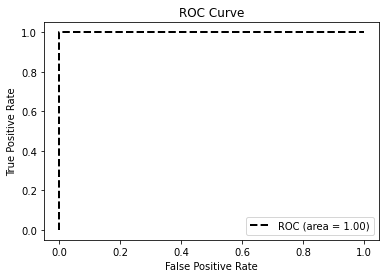

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr, tpr, thersholds = roc_curve(y_label, score, pos_label=1)

roc_auc = auc(fpr, tpr)
print('fpr',fpr)
print('tpr',[i.round(3) for i in tpr])       #保留三位小数
print('roc_auc',roc_auc)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

